In [1]:
# pip install pyarrow grpcio protobuf grpcio-status
from datetime import timedelta

import matplotlib.pyplot as plt
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from pyspark.sql.functions import avg, hour, max, mean, min
from pyspark.sql.types import DayTimeIntervalType


spark = SparkSession.builder.remote('sc://localhost:15002').getOrCreate()
#spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

/Users/admin/Projects/HMG_Softeer_DE/.venv-310/lib/python3.10/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
I0000 00:00:1722751593.099194 2189836 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache


# Data Ingestion

In [2]:
tripdata_df = spark.read.parquet('/Users/admin/Projects/HMG_Softeer_DE/missions/W4/spark-softeer/userdata/NYC-TLC/yellow_tripdata_2024-01.parquet')
#tripdata_df = spark.read.parquet('userdata/NYC-TLC/yellow_tripdata_2024-01.parquet')
tripdata_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|           2|       17.7|  1.0|    0.5|       0.

In [3]:
tripdata_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [4]:
categorical_features = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type']
geo_features = ['PULocationID', 'DOLocationID']

numerical_features = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'tip_amount', 'mta_tax', 'tolls_amount',
                      'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']
time_serial_features = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

# Data Cleaning and Transformation

In [5]:
tripdata_df.describe()

DataFrame[summary: string, VendorID: string, passenger_count: string, trip_distance: string, RatecodeID: string, store_and_fwd_flag: string, PULocationID: string, DOLocationID: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string, congestion_surcharge: string, Airport_fee: string]

In [6]:
tripdata_df = tripdata_df.dropna()
tripdata_df.describe()

DataFrame[summary: string, VendorID: string, passenger_count: string, trip_distance: string, RatecodeID: string, store_and_fwd_flag: string, PULocationID: string, DOLocationID: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string, congestion_surcharge: string, Airport_fee: string]

In [7]:
tripdata_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [8]:
tripdata_interval_df = tripdata_df.withColumn("interval", expr('tpep_dropoff_datetime - tpep_pickup_datetime'))
tripdata_interval_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|            interval|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         18

In [9]:
tripdata_interval_df.select('interval').printSchema()

root
 |-- interval: interval day to second (nullable = true)



In [10]:
filtered_df = (tripdata_interval_df.filter("fare_amount >= 0")
                                   .filter("extra >= 0")
                                   .filter("mta_tax >= 0")
                                   .filter("tip_amount >= 0")
                                   .filter("tolls_amount >= 0")
                                   .filter("improvement_surcharge >= 0")
                                   .filter("total_amount >= 0")
                                   .filter("congestion_surcharge >= 0")
                                   .filter("Airport_fee >= 0")
                                   .filter("interval > (INTERVAL '0000.000000' SECOND)")).cache()
filtered_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|            interval|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         18

In [11]:
filtered_df.describe()

DataFrame[summary: string, VendorID: string, passenger_count: string, trip_distance: string, RatecodeID: string, store_and_fwd_flag: string, PULocationID: string, DOLocationID: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string, congestion_surcharge: string, Airport_fee: string]

# Metrics Calculation

In [12]:
filtered_df.select(avg(col('interval')), avg(col('trip_distance'))).show(1, False)

+------------------------------------------+------------------+
|avg(interval)                             |avg(trip_distance)|
+------------------------------------------+------------------+
|INTERVAL '0 00:15:38.930641' DAY TO SECOND|3.2576161710354428|
+------------------------------------------+------------------+



- 평균 주행 시간 = 15분 38.93초
- 평균 주행 길이 = 3.26 miles

# Peak Hours Analysis

In [13]:
trips_hour_df = filtered_df.groupBy(hour(col('tpep_pickup_datetime'))).count().orderBy('hour(tpep_pickup_datetime)').cache()
trips_hour_df.show(10)

+--------------------------+------+
|hour(tpep_pickup_datetime)| count|
+--------------------------+------+
|                         0| 70981|
|                         1| 46645|
|                         2| 32977|
|                         3| 21354|
|                         4| 13465|
|                         5| 16360|
|                         6| 36637|
|                         7| 76182|
|                         8|107752|
|                         9|122336|
+--------------------------+------+
only showing top 10 rows



In [14]:
max_count = trips_hour_df.select(max('count')).cache().collect()[0]['max(count)']
max_hour = trips_hour_df.select('hour(tpep_pickup_datetime)').filter(col('count') == max_count).collect()[0]['hour(tpep_pickup_datetime)']
print(f'hour: {max_hour} count: {max_count}')

hour: 18 count: 200101


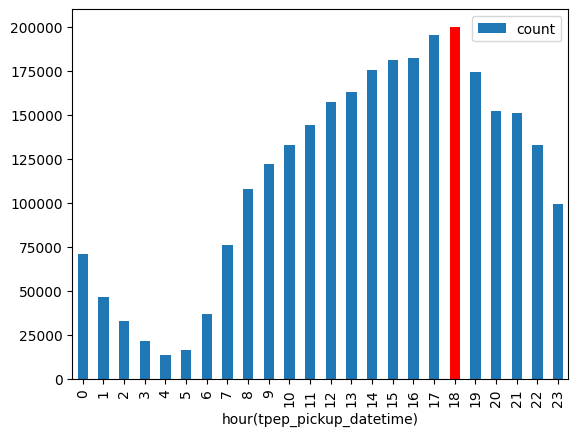

In [15]:
fig, ax = plt.subplots()

trip_pandas_df = trips_hour_df.toPandas()
trip_pandas_df.plot.bar(x='hour(tpep_pickup_datetime)', y='count', ax=ax)

ax.patches[max_hour].set_facecolor('red')

plt.show()

# Weather Condition Analysis

In [16]:
weather_df = pd.read_csv('spark-softeer/userdata/NYC-weather-2024-01-01_2024-02-01.csv', header=0)
weather_df.head()

,Datetime,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition
0,2024-01-01 01:51:00,43 °F,27 °F,53 °%,SW,7 °mph,0 °mph,29.98 °in,0.0 °in,Cloudy
1,2024-01-01 02:51:00,43 °F,27 °F,53 °%,W,9 °mph,0 °mph,29.97 °in,0.0 °in,Cloudy
2,2024-01-01 03:51:00,42 °F,28 °F,58 °%,W,9 °mph,0 °mph,29.97 °in,0.0 °in,Cloudy
3,2024-01-01 04:51:00,42 °F,29 °F,60 °%,W,7 °mph,0 °mph,29.96 °in,0.0 °in,Cloudy
4,2024-01-01 05:51:00,42 °F,29 °F,60 °%,WSW,5 °mph,0 °mph,29.96 °in,0.0 °in,Cloudy


In [17]:
weather_df['Hour'] = weather_df['Datetime'].map(lambda x: int(x.split(' ')[1][:2]))
weather_df['Temperature'] = weather_df['Temperature'].map(lambda x:float(x.replace('°F', '')))
weather_df['Dew Point'] = weather_df['Dew Point'].map(lambda x: float(x.replace('°F', '').strip()))
weather_df['Humidity'] = weather_df['Humidity'].map(lambda x: float(x.replace('°%', '').strip()))
weather_df['Wind Speed'] = weather_df['Wind Speed'].map(lambda x: float(x.replace('°mph', '').strip()))
weather_df['Wind Gust'] = weather_df['Wind Gust'].map(lambda x: float(x.replace('°mph', '').strip()))
weather_df['Pressure'] = weather_df['Pressure'].map(lambda x: float(x.replace('°in', '').strip()))
weather_df['Precip.'] = weather_df['Precip.'].map(lambda x: float(x.replace('°in', '').strip()))

In [18]:
weather_df.columns = [
    "Datetime", 
    "Temperature(°F)", "Dew Point(°F)", 
    "Humidity(°%)", 
    "Wind", "Wind Speed(°mph)", "Wind Gust(°mph)", 
    "Pressure(°in)", "Precip.(°in)", 
    "Condition", "Hour"
]

In [19]:
weather_df['Wind'].unique()

array(['SW', 'W', 'WSW', 'WNW', 'NW', 'NNW', 'N', 'CALM', 'NE', 'S',
       'NNE', 'ENE', 'E', 'SE', 'ESE', 'SSE', 'SSW', 'VAR'], dtype=object)

In [20]:
weather_df.head()

,Datetime,Temperature(°F),Dew Point(°F),Humidity(°%),Wind,Wind Speed(°mph),Wind Gust(°mph),Pressure(°in),Precip.(°in),Condition,Hour
0,2024-01-01 01:51:00,43.0,27.0,53.0,SW,7.0,0.0,29.98,0.0,Cloudy,1
1,2024-01-01 02:51:00,43.0,27.0,53.0,W,9.0,0.0,29.97,0.0,Cloudy,2
2,2024-01-01 03:51:00,42.0,28.0,58.0,W,9.0,0.0,29.97,0.0,Cloudy,3
3,2024-01-01 04:51:00,42.0,29.0,60.0,W,7.0,0.0,29.96,0.0,Cloudy,4
4,2024-01-01 05:51:00,42.0,29.0,60.0,WSW,5.0,0.0,29.96,0.0,Cloudy,5


In [21]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Datetime          938 non-null    object 
 1   Temperature(°F)   938 non-null    float64
 2   Dew Point(°F)     938 non-null    float64
 3   Humidity(°%)      938 non-null    float64
 4   Wind              938 non-null    object 
 5   Wind Speed(°mph)  938 non-null    float64
 6   Wind Gust(°mph)   938 non-null    float64
 7   Pressure(°in)     938 non-null    float64
 8   Precip.(°in)      938 non-null    float64
 9   Condition         938 non-null    object 
 10  Hour              938 non-null    int64  
dtypes: float64(7), int64(1), object(3)
memory usage: 80.7+ KB


In [22]:
weather_df = ps.from_pandas(weather_df).to_spark()
print(type(weather_df))

<class 'pyspark.sql.connect.dataframe.DataFrame'>


/Users/admin/Projects/HMG_Softeer_DE/.venv-310/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [23]:
trip_weather_df = filtered_df.join(weather_df, hour(filtered_df['tpep_pickup_datetime']) == weather_df['Hour'], 'inner')
trip_weather_df = trip_weather_df.select('Datetime', 'Temperature(°F)', 'Dew Point(°F)', 'Humidity(°%)', 
                                         'Wind', 'Wind Speed(°mph)', 'Wind Gust(°mph)', 
                                         'Pressure(°in)', '`Precip.(°in)`', 'Condition', 'Hour')
trip_weather_df = trip_weather_df.toDF('Datetime', 'Temperature', 'Dew Point', 'Humidity', 
                                            'Wind', 'WindSpeed', 'Wind Gust', 'Pressure', 'Precip', 'Condition', 'Hour')
trip_weather_df.show(5)

+-------------------+-----------+---------+--------+----+---------+---------+--------+------+----------+----+
|           Datetime|Temperature|Dew Point|Humidity|Wind|WindSpeed|Wind Gust|Pressure|Precip| Condition|Hour|
+-------------------+-----------+---------+--------+----+---------+---------+--------+------+----------+----+
|2024-01-31 00:51:00|       40.0|     30.0|    68.0|  NW|      5.0|      0.0|   30.04|   0.0|    Cloudy|   0|
|2024-01-30 00:51:00|       35.0|     28.0|    76.0|  SE|     10.0|      0.0|   30.16|   0.0|Light Snow|   0|
|2024-01-29 00:51:00|       36.0|     25.0|    64.0|   N|     10.0|      0.0|   30.09|   0.0|    Cloudy|   0|
|2024-01-28 00:51:00|       38.0|     34.0|    86.0|   N|     10.0|      0.0|   29.61|   0.0|Light Rain|   0|
|2024-01-27 00:51:00|       43.0|     36.0|    76.0| ESE|      6.0|      0.0|   30.14|   0.0|    Cloudy|   0|
+-------------------+-----------+---------+--------+----+---------+---------+--------+------+----------+----+
only showi

In [24]:
hour_condition_pivot = trip_weather_df.groupBy('Hour').pivot('Condition').count().orderBy('Hour')
hour_condition_pivot.show(24)

+----+-------+--------------+---------------+-------+------------+------+----------+------------------+-------------+-------------------+----------+------------------+----------+------------------+--------------------+------+-------------+---------------------+-------------+---------------------+------+------------+----------+
|Hour| Cloudy|Cloudy / Windy|Drizzle and Fog|   Fair|Fair / Windy|   Fog|Heavy Rain|Heavy Rain / Windy|Light Drizzle|Light Freezing Rain|Light Rain|Light Rain / Windy|Light Snow|Light Snow / Windy|Light Snow and Sleet|  Mist|Mostly Cloudy|Mostly Cloudy / Windy|Partly Cloudy|Partly Cloudy / Windy|  Rain|Rain / Windy|Wintry Mix|
+----+-------+--------------+---------------+-------+------------+------+----------+------------------+-------------+-------------------+----------+------------------+----------+------------------+--------------------+------+-------------+---------------------+-------------+---------------------+------+------------+----------+
|   0| 425886

In [25]:
columns = list(hour_condition_pivot.columns[1:])
x = list(range(24))

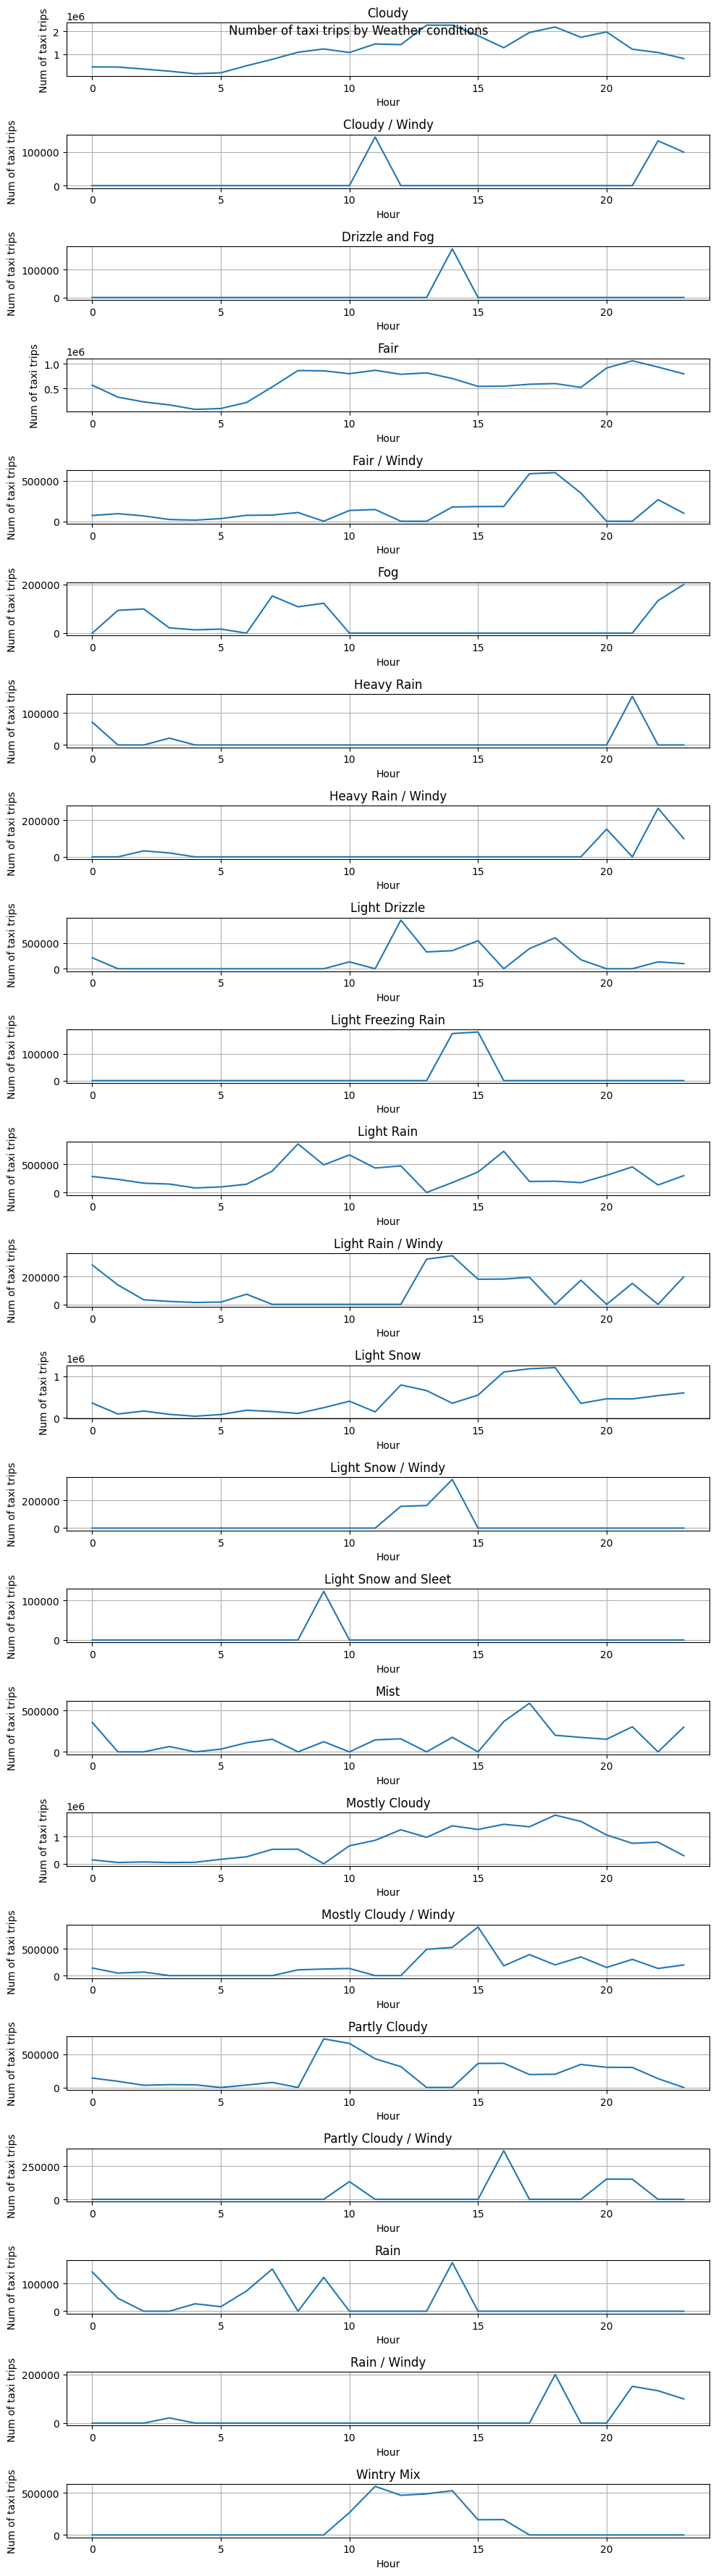

In [26]:
fig, axes = plt.subplots(nrows=len(columns), figsize=(10, 36))

fig.suptitle('Number of taxi trips by Weather conditions')
fig.tight_layout()

for i in range(len(columns)):
    ax = axes[i]

    ax.set_title(columns[i])
    ax.set_xlim(-1, 24)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Num of taxi trips')
    ax.grid()

    y = hour_condition_pivot.select(columns[i])
    y = [int(row[columns[i]]) if row[columns[i]] is not None else 0 for row in y.collect()]

    ax.plot(x, y)

plt.tight_layout()
plt.show()

In [27]:
trip_weather_df.select(min(col('Temperature')), max(col('Temperature')), mean(col('Temperature'))).show()

+----------------+----------------+-----------------+
|min(Temperature)|max(Temperature)| avg(Temperature)|
+----------------+----------------+-----------------+
|            19.0|            59.0|37.80071389859209|
+----------------+----------------+-----------------+



In [28]:
hour_temperature_pivot = trip_weather_df.select('Hour', 'Temperature').groupBy('Hour').pivot('Temperature')
hour_temperature_pivot = hour_temperature_pivot.count().orderBy('Hour')

hour_temperature_pivot.show(24)

+----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-------+------+-------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|Hour|  19.0|  20.0|  21.0|  22.0|  23.0|  24.0|  25.0|  26.0|  27.0|  28.0|  29.0|  30.0|  31.0|  32.0|  33.0|  34.0|  35.0|  36.0|   37.0|  38.0|   39.0|  40.0|  41.0|  42.0|  43.0|  44.0|  45.0|  46.0|  47.0|  48.0|  49.0|  50.0|  51.0|  52.0|  53.0|  54.0|  55.0|  56.0|  57.0|  59.0|
+----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-------+------+-------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|   0|  NULL|  NULL|  NULL| 70981|  NULL|141962|212943|141962| 70981| 70981| 70981|  NULL|  NULL|  NULL| 70981|  NULL|212943|212943| 

In [29]:
pivot_df = hour_temperature_pivot.toPandas()
pivot_df = pivot_df.set_index('Hour')

In [30]:
for i in range(len(pivot_df)):
    pivot_df.iloc[i] = pivot_df.iloc[i].map(lambda x: 0.0 if pd.isna(x) else float(x))

In [31]:
pivot_df.head()

,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,...,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,59.0
Hour,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,70981.0,0.0,141962.0,212943.0,141962.0,70981.0,70981.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141962.0,70981.0,0.0
1,0.0,0.0,0.0,46645.0,93290.0,0.0,0.0,139935.0,46645.0,0.0,...,46645.0,0.0,0.0,0.0,0.0,0.0,46645.0,0.0,0.0,0.0
2,0.0,0.0,0.0,32977.0,32977.0,65954.0,0.0,164885.0,32977.0,32977.0,...,0.0,32977.0,0.0,0.0,0.0,65954.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,42708.0,21354.0,21354.0,0.0,85416.0,0.0,21354.0,...,42708.0,21354.0,21354.0,0.0,0.0,42708.0,42708.0,0.0,0.0,0.0
4,0.0,13465.0,13465.0,0.0,13465.0,13465.0,13465.0,13465.0,13465.0,13465.0,...,0.0,26930.0,0.0,0.0,13465.0,40395.0,0.0,0.0,0.0,0.0


In [32]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 23
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   19.0    24 non-null     float64
 1   20.0    24 non-null     float64
 2   21.0    24 non-null     float64
 3   22.0    24 non-null     float64
 4   23.0    24 non-null     float64
 5   24.0    24 non-null     float64
 6   25.0    24 non-null     float64
 7   26.0    24 non-null     float64
 8   27.0    24 non-null     float64
 9   28.0    24 non-null     float64
 10  29.0    24 non-null     float64
 11  30.0    24 non-null     float64
 12  31.0    24 non-null     float64
 13  32.0    24 non-null     float64
 14  33.0    24 non-null     float64
 15  34.0    24 non-null     float64
 16  35.0    24 non-null     float64
 17  36.0    24 non-null     float64
 18  37.0    24 non-null     int64  
 19  38.0    24 non-null     float64
 20  39.0    24 non-null     float64
 21  40.0    24 non-null     float64
 22  41.0    2

/var/folders/yw/mg4v6y8j72qg1fzcmj55kkhr0000gn/T/ipykernel_36261/181017918.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(pivot_df.columns[::5])


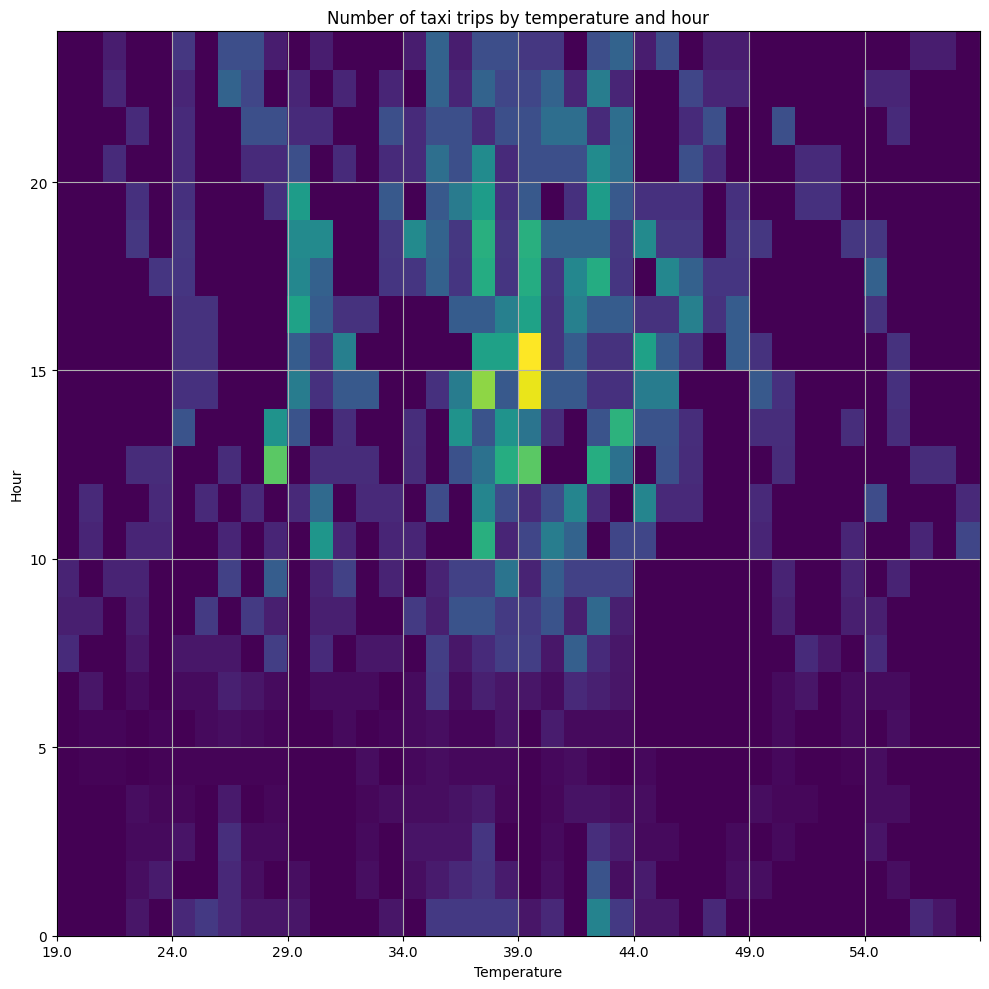

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title('Number of taxi trips by temperature and hour')
ax.set_xlabel('Temperature')
ax.set_ylabel('Hour')
ax.set_xticklabels(pivot_df.columns[::5])
ax.grid()

ax.pcolor(pivot_df)

plt.tight_layout()
plt.show()

In [34]:
spark.stop()